# AE2 - Dan Cho

##### Introduction

This project attempts to determine whether tweets posted by billionaire entrepreneur Elon Musk have an effect on the stock prices for 'meme' cryptocurrency 'Dogecoin.' In the past decade, social media has become incredibly prevalent and widespread for people of all ages, some of the most popular platforms belonging to just Meta (Facebook, Instagram, and Whatsapp). However, one of the most influential is Twitter. It is an app where users upload short messages to their profile, each having a limit of 280 characters, although most 'tweets' are below 100 characters or even a couple words. Because of the way tweets are designed, users often treat tweets as 'status updates' and tweet anything clever or interesting that goes in their lives. As a result, Twitter has become a platform for celebrities to share their opinions, seen by millions and millions of people. From your friend to the President of the United States, Twitter is truly influential. In particular, Elon Musk tweets multiple times a day, and due to his billionaire status and online charm, his tweets with 'doge' may have an affect on dogecoin prices. Sentiment analysis will be applied on Elon's 'doge' tweets to collect the polarities from the tweets, which will be plotted against the difference between Dogecoin's closing price and the day before's, matched by date.

In [1]:
# modules
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer as sia
import seaborn as sns
from scipy import stats


##### Importing Modules


The modules listed below will be used in this project. Pandas will be used to organise and modify the data. Regular expressions is convenient for 'cleaning' textual data, which we have in Elon's tweets. The dataframes can be plotted using the Matplotlib.pyplot module. This module contains many methods to graph and visualise our findings. The NLTK module (Natural Language Toolkit) is a package with many methods to handle 'human language data,' such as tweets. We will use the SentimentIntensityAnalyser from the NLTK library for the sentiment analysis. The Seaborn module is also used for visualising analyses, but it specialises in drawing statistical graphs, such as linear regression. Lastly, the Scipy module will be used to provide common statistical measures for our linear regression.

## Preprocessing 

#### Elon Musk Tweets

In [2]:
# Reading the elon musk tweet data
_20_19 = pd.read_csv('elontweets/2020.csv') #includes data from 2010-2020
_21 = pd.read_csv('elontweets/2021.csv')
_22 = pd.read_csv('elontweets/2022.csv')

# Combine the datasets 
elon_data = pd.concat([_20_19[6261::-1], _21[::-1], _22[::-1]], ignore_index = True)
'''This slice includes the portion of data from 2019-2020, 
    which is when Elon first started to tweet Doge
'''
# Keeping the date and tweet columns
elon_data = elon_data[['date', 'tweet']]

# Cleaning away user mentions and links for tweets
cleaned_tweets = [re.sub('@\S+ |http\S+','', tweet) for tweet in elon_data.tweet]
elon_data['tweet'] = cleaned_tweets

# Changing all dates into datetime objects
elon_data.date = pd.to_datetime(elon_data.date)

# Collecting the Doge data
elon_doge = elon_data[elon_data['tweet'].str.contains('doge', case=False)]
elon_doge.reset_index(drop = True, inplace = True)

pd.set_option('display.max_rows', None)
elon_doge.head()


,date,tweet
0,2019-04-02 09:24:39,Dogecoin might be my fav cryptocurrency. It’s ...
1,2019-04-02 20:16:58,Dogecoin rulz
2,2019-04-02 20:38:38,Dogecoin value may vary
3,2020-04-25 13:29:52,Dogecoin Mode
4,2020-07-18 00:53:43,"Excuse me, I only sell Doge!"


##### Data Sources and Methods (Elon data)

Elon Musk Twitter Data : https://www.kaggle.com/datasets/ayhmrba/elon-musk-tweets-2010-2021?
(Downloaded csvs '2020,' and '2021,' and '2022.' The 2022 dataset was updated to 5/3/22 when I analysed it.

First, I read the three csvs into three pandas dataframes. Elon first tweet that mentioned 'doge' was in 2019, so I only chose to download the relevant datasets from 20', 21', and 22'. Next, I concatenated the three dataframes into one comprehensive dataframe. The datasets were originally organised by descending date, so I applied a stepper of -1 to make the data values from the earliest to latest date. The 20' dataset contained the data from not only 2020 but also every year before than, so I only concatenated the portion of the dataset that contained 2019, which began in index 6261. With the dataframe completed, I made a new dataframe of the same name with columns 'date,' and 'tweet,' the only columns I was interested in. Now, it was time to clean the tweets. I used regular expressions to remove user mentions and links from the tweets, and replaced the 'tweet' values with the cleaned tweets values. Links and usernames that contained 'doge' shouldn't count as mentions because they were not intended to reference doge, which is why I cleaned them from the tweets. Next, I used the to_datetime method to convert the date values (which were originally strings) into proper datetime values because matplotlib treats string data as categorical data. Finally, I needed to disregard any tweets that did not mention 'doge, so I used boolean indexing to make a new dataframe that only contained doge-related data. The old indexes were kept, however, so I applied a reset_index.

#### Dogecoin stock prices

In [3]:
# Read Yahoo Dogecoin price data
doge_data = pd.read_csv('DOGE-USD.csv')

# Changing all dates into datetime objects
doge_data['Date'] = pd.to_datetime(doge_data.Date)

# Select relevant data
doge_data = doge_data[['Date', 'Close']]
doge_data.set_axis({'date': 'Date', 'close': 'Close'}, axis = 1,  inplace = True)
doge_data['pclose'] = doge_data.close.shift(1)
doge_data['pclose'][0] = doge_data.iloc[0]['close']
doge_data['diff'] = abs(doge_data.pclose - doge_data.close)

doge_data.head()


/var/folders/s0/kwfsjn3d5qd4qzpzzzw65x7c0000gn/T/ipykernel_37729/4049621529.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_data['pclose'][0] = doge_data.iloc[0]['close']


,date,close,pclose,diff
0,2019-01-01,0.002392,0.002392,0.000000
1,2019-01-02,0.002407,0.002392,0.000015
2,2019-01-03,0.002360,0.002407,0.000047
3,2019-01-04,0.002315,0.002360,0.000045
4,2019-01-05,0.002319,0.002315,0.000004


##### Data Sources and Methods (Dogecoin data)

Dogecoin Price Data: https://finance.yahoo.com/quote/DOGE-USD/history?p=DOGE-USD 
(Downloaded data from the period 2019-01-01 to 2022-03-05

Likewise, for the dogecoin data I used the csv reader to make a pandas dataframe. I converted the string dates into proper datetime values as before. I made a new dataframe with just the 'date' and 'close' columns, 'close' representing closing price. The capitalised labels were annoying, so I quickly replaced them with their lowercase equivalents. Now, I didn't want to compare the closing prices because they didn't seem indicative, so I decided to compare the difference between the closing price of the day and previous day. To do this, I first made a new column 'pclose,' which is to represent the previous closing price. The values for 'pclose' are just the 'close' values but shifted down. Of course, the first dataset doesn't have a previous value, so I kept it the same as the 'close' value. Finally, I made the column 'diff,' which is the absolute value of the difference between the two closing prices.

# Analysis

### Quick Visualisation

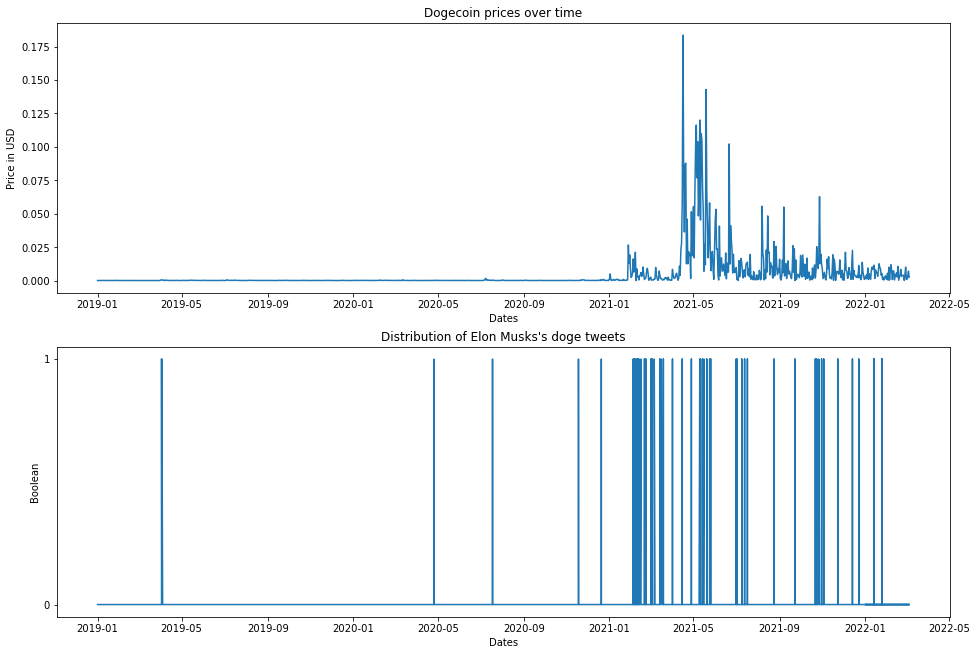

In [4]:
# Comparing the two datasets side-by-side 
fig, (ax1, ax2) = plt.subplots(2, figsize = (16, 6))
plt.subplots_adjust(top = 1.5)

ax1.plot(doge_data['date'], doge_data['diff'])
ax1.set_xlabel('Dates')
ax1.set_ylabel('Price in USD')
ax1.set_title('Dogecoin prices over time')

elon_data['bool'] = elon_data['tweet'].str.contains('doge', case=False).astype(int)
ax2.plot(elon_data['date'], elon_data['bool'])
ax2.set_yticks([0,1])
ax2.set_xlabel('Dates')
ax2.set_ylabel('Boolean')
ax2.set_title('Distribution of Elon Musks\'s doge tweets')

plt.show()


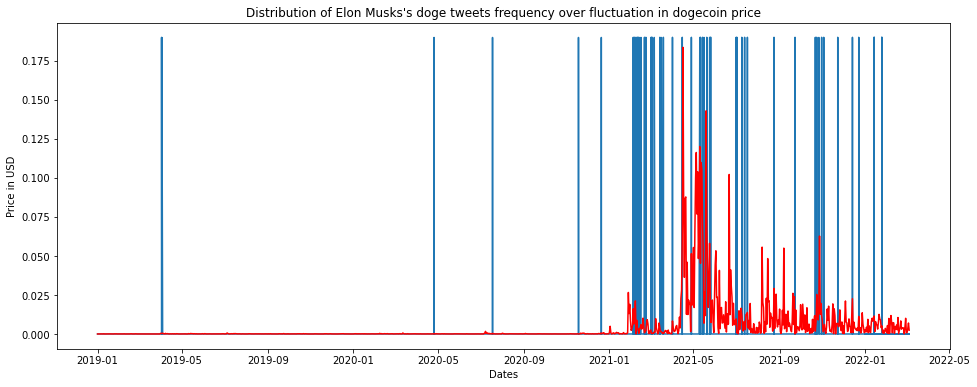

In [5]:
# Overlaying the two datasets for better visual 
elon_data['bool'] = elon_data['tweet'].str.contains('doge', case=False).astype(int)
elon_data['bool'] = elon_data['bool'] * .19

fig, ax = plt.subplots(figsize = (16, 6))
ax.plot(elon_data['date'], elon_data['bool'])
ax.plot(doge_data['date'], doge_data['diff'], c = 'red')
ax.set_xlabel('Dates')
ax.set_ylabel('Price in USD')
ax.set_title('Distribution of Elon Musks\'s doge tweets frequency over fluctuation in dogecoin price')

plt.show()


##### Analysis and Results (Quick Visualisation)

Now I wanted to plot the datasets just to get a visualisation of what I can expect from this data, so not a true analysis persay. To comapre the two datasets side-by-side, I used matplotlib to create a figure with two subplots. The first suplot was the dogecoin prices, in which I plotted the dogedata dates against the diff price. The second subplot is a little more interesting. I wanted to show the distribution of elon's doge tweets over time, so I made an boolean array in elon_data['bool']. Matplotlib can't plot booleans as numerical data so I changed them to type(int). From the visualisation, you can see the spikes in dogecoin diff from beyond 2021-01, which coincidentally is when Elon's made a lot of doge tweets. In the second plot, I overlayed the two graphs on top of each other. I broadcasted a value onto the boolean array to make the numbers smaller and accomodate the diff prices, which is fine since the boolean values themselves are arbitrary whether it's 0 and 1 or 0 and .19, I just needed them to show up on the graph beside the diff values.

## Correlation and Regression

### Sentimental Analysis

In [6]:
# Download VADER model from nltk, a sentimental analysis tool designed for social media text
nltk.download('vader_lexicon')

testsis = sia()
testsis.polarity_scores('And guess what? You happen to hold a wrong one. \
                   And I hope you know that your opinion is now illegal.')
elon_doge.loc[:, 'polarity'] = [testsis.polarity_scores(twt)['compound'] for twt in elon_doge['tweet']]

elon_doge.head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dcho4/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/s0/kwfsjn3d5qd4qzpzzzw65x7c0000gn/T/ipykernel_37729/3589306123.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elon_doge.loc[:, 'polarity'] = [testsis.polarity_scores(twt)['compound'] for twt in elon_doge['tweet']]


,date,tweet,polarity
0,2019-04-02 09:24:39,Dogecoin might be my fav cryptocurrency. It’s ...,0.8176
1,2019-04-02 20:16:58,Dogecoin rulz,0.0000
2,2019-04-02 20:38:38,Dogecoin value may vary,0.3400
3,2020-04-25 13:29:52,Dogecoin Mode,0.0000
4,2020-07-18 00:53:43,"Excuse me, I only sell Doge!",0.1511


##### Analysis and Results (Sentimental Analysis)

To get the sentimental analysis, I decided to use the VADER (Valence Aware Dictionary for sEntiment Reasoning) lexicon from the NLTK library to base my sentiment analyses. This lexicon is designed to work with social media language because it is equipped to interpret numerous slang and texting mannerisms. I initialised the SentimentIntensityAnalyzer object to use the polarity_scores method. I made a new column under elon_doge by assigning it polarity scores for each tweet using list comprehension. 

### Plotting the Linear Regression

In [7]:
# Extract doge prices on days where he tweeted
doge_data['date'] = doge_data['date'].astype(str)
elon_doge['date'] = elon_doge.date.astype(str).apply(lambda x: x[:10])

doge_data['bools'] = doge_data.date.isin(elon_doge.date)
doge_new = doge_data.loc[doge_data.bools, ['date','diff']]
doge_new.reset_index(drop = True, inplace = True)

doge_new['polarity'] = elon_doge.groupby('date', as_index = False).mean().polarity

doge_new.head()


/var/folders/s0/kwfsjn3d5qd4qzpzzzw65x7c0000gn/T/ipykernel_37729/2316553173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elon_doge['date'] = elon_doge.date.astype(str).apply(lambda x: x[:10])


,date,diff,polarity
0,2019-04-02,0.000334,0.385867
1,2020-04-25,0.000039,0.000000
2,2020-07-18,0.000412,0.151100
3,2020-11-17,0.000050,0.000000
4,2020-12-20,0.000698,0.000000


r: 0.22754627693427784
r-squared = 0.05177730814665107
p: 0.11585537580685137


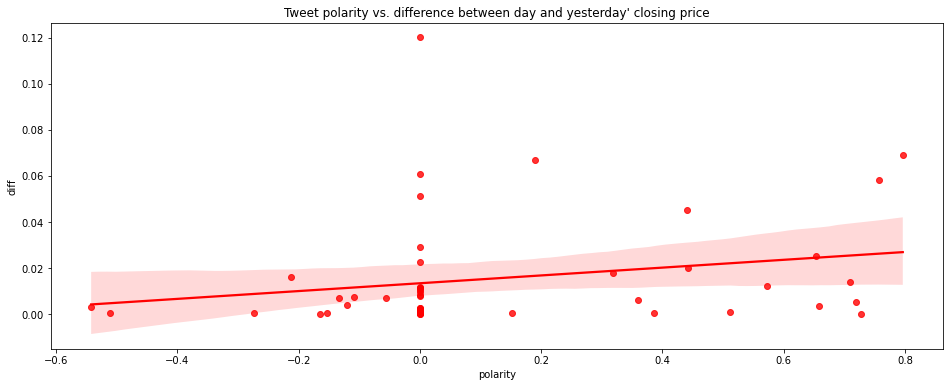

In [8]:
# Determining if there is correlation between stock prices and elon's doge sentimentality
fig, ax = plt.subplots(figsize= (16, 6))
sns.regplot(x = doge_new['polarity'], y = doge_new['diff'], color='red', fit_reg=True)

plt.title('Tweet polarity vs. difference between day and yesterday\' closing price')
                                                   
# test correlation
corr = stats.pearsonr(doge_new['polarity'], doge_new['diff'])
print('r: ' +str(corr[0]) + '\nr-squared = '+str(corr[0] ** 2)+'\np: ' + str(corr[1]))


##### Analysis and Results (Plotting the Linear Regression)

The first cell under this section deals with organising the data to be neatly graphed using the seaborn and matplotlib libraries. We want to plot polarity against diff for each tweet so we made the doge_new dataframe. First, we had to group the polarities and corresponding diff prices by date. Therefore, to determine whether the data is a match, we would have to compare the dates, and if they were the same it would be a match. However, the dateobjects in elon_doge and doge_data were not the same format (elon_doge includes h/m/s) so matches wouldn't be interpreted as matches. Thus, we converted the 'date's back into strings, while using .apply to strip the h/m/s after the y/m/d for elon_doge. Datetime objects are not subscriptable, which is why we had to change them to strings. Finally we used the .isin function to compare the dates and create a boolean array column in doge_data. Then we indexed the boolean values and created a new dataframe doge_new with the date and diff columns. We applied reset_index to restart the index from 0. Finally we added the 'polarity' column, in which we used .groupby. We couldn't just add elon_doge.date because there were duplicate dates present (Elon tweeted multiple times in one day). Luckily, with .groupby we can apply .mean onto those duplicates to get the mean polarity and diff.

To test correlation, we created a regplot figure using the seaborn module. Our two axes were the polarity and the diff. After plotting, used the scipy.stats to computate the r, r-squared, and p-values.

## Conclusions

Although the quick visualisations seemed promising, after analysing the linear regression and related statistics, based off this model, we cannot conclude there is a correlation between elon musk's 'doge' tweets and the dogecoin price. The p-value of 11% is nearly double the figure of 5%, which is often considered the maximum percentage allowed to consider the results statistically significant. Furthermore, the r and r-squared values are fairly low. Generally, an r-squared value above 70% shows high correlation and above 40% shows moderate correlation. Our value of 5% indicates extremely low correlation, if any. However, it is unfair to simply conclude that the linear regression failed. The sample size of elon musk 'doge' tweets is extremely small, at a count of 69. Statisticians often consider a count of 100 the absolute minimum sample size to be considered meaninful. Nearly 200 billion tweets are posted annually on Twitter, so for this project, it may have been wise considering to not limit the 'doge' tweets to just Elon Musk but consider all's 'doge' tweets, although that sample may become too overwhelming. A middle ground can be found. Another reason for our low statistical significance could simply be that linear regression is not the tool best to analyse these data. Perhaps a price and sentiment time-series or considering price volatility could offer meaningful results. These would likely be the approaches I would consider when I redo this project.

### References

Elon Musk Twitter Data : https://www.kaggle.com/datasets/ayhmrba/elon-musk-tweets-2010-2021?
(Downloaded csvs '2020,' and '2021,' and '2022.' The 2022 dataset was updated to 5/3/22 when I analysed it.

Dogecoin Price Data: https://finance.yahoo.com/quote/DOGE-USD/history?p=DOGE-USD 
(Downloaded data from the period 2019-01-01 to 2022-03-05

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

https://www.nltk.org/_modules/nltk/sentiment/vader.html 